**Note:**

This version focusses on training a NN that can perform well for a range of global pauli y biases as those are the bias the MWPM performs poorly against.

In [1]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

# Imports
import jax
import jax.numpy as jnp
from jax import grad, vmap, jit, value_and_grad
import optax

import numpy as np

from pymatching import Matching

import matplotlib.pyplot as plt

from packages.quantum_error_correction import *
from packages.neural_network import *

from icecream import ic  # For debugging

key = jax.random.key(64)

# Initialize the QEC code that will be used

Rate of non-trivial cases: 53.30%


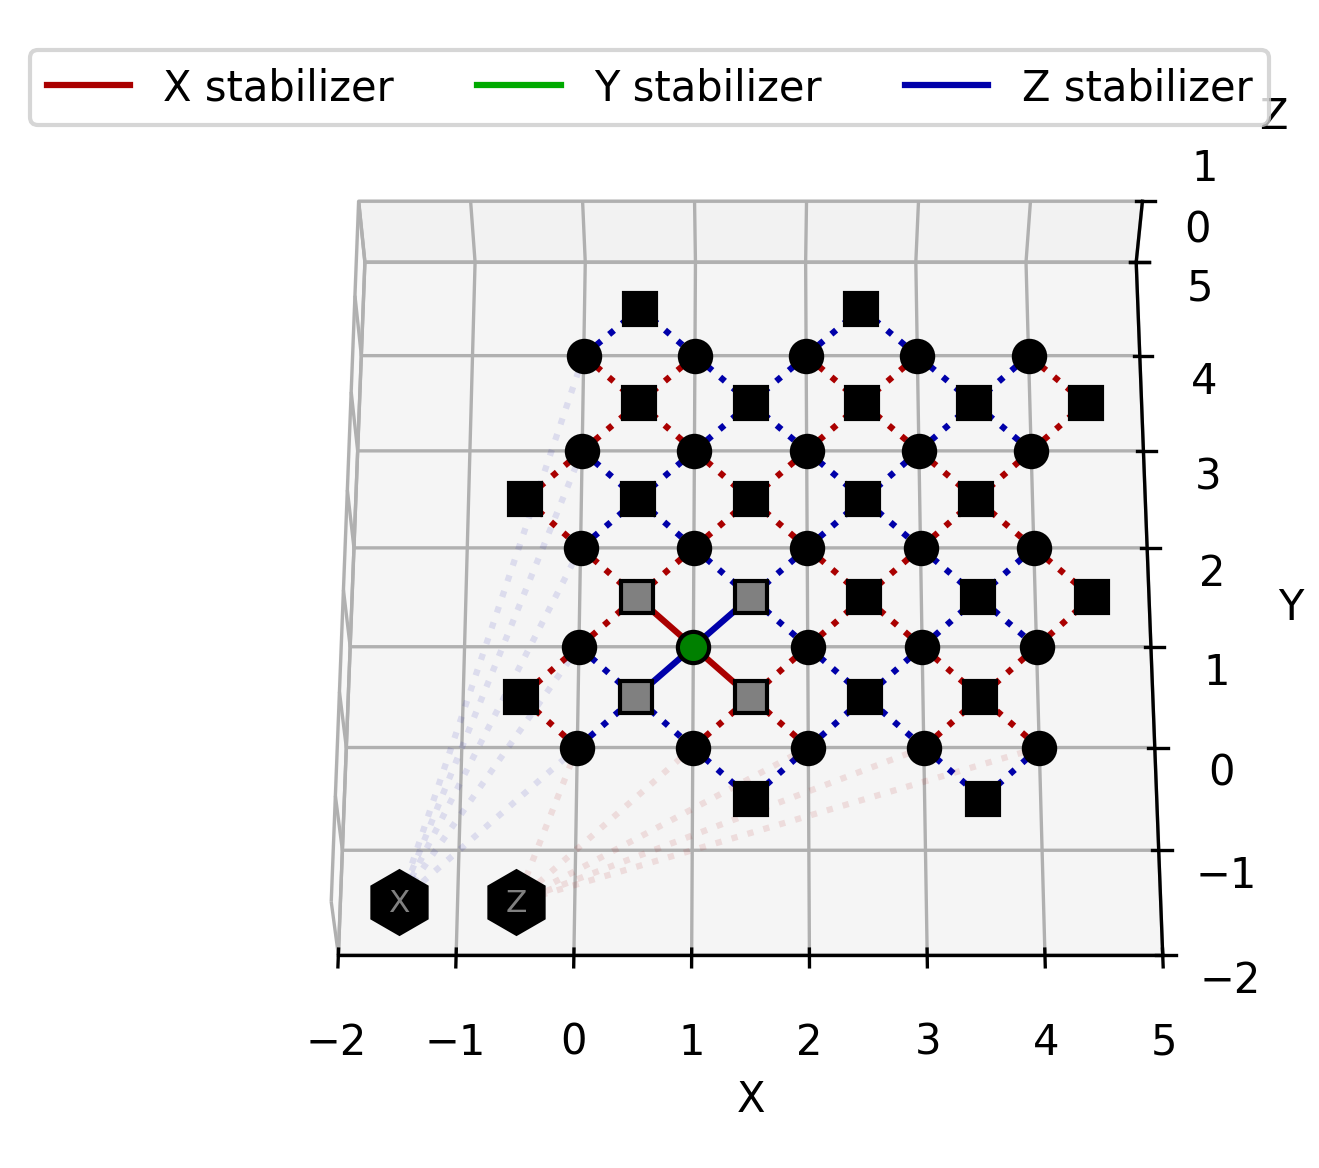

In [2]:
p = .03
nu = 100
error_prob = [
    1 / (2 * (nu + 1)) * p,
    nu / (nu + 1) * p,
    1 / (2 * (nu + 1)) * p,
]
# error_prob = [.01, .01, .01]
code_distance = 5

subkey, key = jax.random.split(key)
errors = jax_create_error_batch(*error_prob, size=code_distance**2, batch_size=10, key=subkey)

qec = QEC(surface_code_data_wls(d=code_distance))
info = {}
info['Mx'], info['My'], info['Mz'] = qec.transformation_matrix()
# Split into matrix for syndrome qubits in logical detectors
info['Sx'], info['Lx'] = info['Mx'][:-2], info['Mx'][-2:]
info['Sy'], info['Ly'] = info['My'][:-2], info['My'][-2:]
info['Sz'], info['Lz'] = info['Mz'][:-2], info['Mz'][-2:]
nsq, ndq = info['Sx'].shape
qec.show(errors=errors[0]);

print(f'Rate of non-trivial cases: {1-(1-sum(error_prob))**ndq:.2%}')

syndromes = jax_get_syndromes_batch(info['Sx'], info['Sy'], info['Sz'], errors)
logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], errors)

# Create data function

In [3]:
def jax_create_error_batch(px: float, py: float, pz: float, size: int, batch_size: int, key) -> jnp.ndarray:
    rand = jax.random.uniform(key, shape=(batch_size, size))
    result = jnp.zeros_like(rand, dtype=jnp.int32)  # Initialize with zeros (default case)

    # Apply conditions sequentially
    result = jnp.where(rand < px + py + pz, 1, result)  # Check for px+py+pz first
    result = jnp.where(rand < py + pz, 2, result)      # Check for py+pz next
    result = jnp.where(rand < pz, 3, result)          # Check for pz last

    return result

def gen_data(error_prob: list, info: dict, ndq: int, batch_size: int, key):
    errors = jax_create_error_batch(*error_prob, size=ndq, batch_size=batch_size, key=key)

    syndromes = jax_get_syndromes_batch(info['Sx'], info['Sy'], info['Sz'], errors)
    logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], errors)

    return syndromes, logicals

subkey, key = jax.random.split(key)
syndromes, logicals = gen_data(error_prob, info, ndq, batch_size=10, key=subkey)
print("Syndromes:")
print(syndromes)
print("\nLogicals:")
print(logicals)

Syndromes:
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1]
 [0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]

Logicals:
[[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 1]
 [0 0]
 [0 0]
 [0 0]]


# Create the NN

In [4]:
def NN(syndromes, error_weights, params):
    # Change from 0, 1 inputs to -1, 1
    syndromes = jnp.append(2*syndromes - 1, error_weights)

    num_layers = len(params['weights'])
    for layer_idx, (w, b) in enumerate(zip(params['weights'], params['biases'])):
        syndromes = jnp.matmul(w, syndromes) + b
        if layer_idx < num_layers-1:
            syndromes = jax.nn.relu(syndromes)
    return syndromes


NN_batch = jax.vmap(NN, in_axes=[0, None, None], out_axes=0)

# Initialize the NN
with random weights and biases

In [4]:
subkey, key = jax.random.split(key)
num_neurons_layers = [nsq+3, 20, 15, 10, 5, 2]
params = NN_init_params( subkey, num_neurons_layers )
print(f"Layers: {num_neurons_layers}")

b_count = 0
for b in params['biases']:
    b_count += b.shape[0]
print(f'Bias parameters: {b_count}')

w_count = 0
for w in params['weights']:
    w_count += w.shape[0] * w.shape[1]
print(f'Weight parameters: {w_count}')

print(f'Total: {b_count+w_count}')

Layers: [27, 20, 15, 10, 5, 2]
Bias parameters: 52
Weight parameters: 1050
Total: 1102


# Cost function

In [6]:
def mse_loss_batch(NN_input: list[jnp.ndarray], params: dict, logicals: jnp.ndarray) -> jnp.ndarray:
    """
    Uses the Binary Cross Entropy (BCE) to evaluate the performance of the NN
    """
    NN_logicals = NN_batch(*NN_input, params)
    return optax.sigmoid_binary_cross_entropy(NN_logicals, logicals).mean()

mse_loss_batch_val_grad = value_and_grad(mse_loss_batch, argnums=1)
mse_loss_batch_val_grad = jax.jit(mse_loss_batch_val_grad)

# Test it on the randomly initiated NN

In [7]:
# Generate data
subkey, key = jax.random.split(key)
syndromes, logicals = gen_data(error_prob, info, ndq, batch_size=1000, key=subkey)

error_weights = jnp.log(jnp.array(error_prob)) / jnp.log(max(error_prob))
print(error_weights)
print()

NN_input = [syndromes, error_weights]

# Run the neural network
NN_probs = jax.nn.sigmoid(NN_batch(*NN_input, params))
NN_logicals = jnp.where(NN_probs>0.5, 1, 0)
print(NN_probs)

# Evaluate the neural networks performance
mse_loss_batch(NN_input, params, logicals)

[2.5066986 1.        2.5066986]

[[0.5267679  0.47380364]
 [0.52899295 0.471626  ]
 [0.53190655 0.46877423]
 ...
 [0.5        0.5       ]
 [0.5        0.5       ]
 [0.52899295 0.471626  ]]


Array(0.6926718, dtype=float32)

# Train the NN

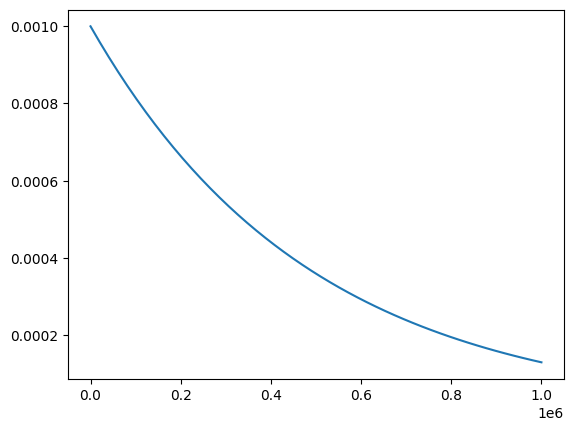

In [5]:
init_value = 1E-3
transition_steps = 25_000
decay_rate = 0.95

count = jnp.linspace(0, 1_000_000)

rate_factor = count / transition_steps
decayed_value = init_value * (decay_rate ** rate_factor)

plt.figure()
plt.plot(count, decayed_value)
plt.show()

learning_rate = optax.exponential_decay(
    init_value = 1E-3,
    transition_steps = 50_000,
    decay_rate = 0.95
)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(params)

losses=[]
idx_batch = 0
T = {
    'Data generation ': 0, 
    'loss + grad calc': 0, 
    'Safe guard      ': 0, 
    'Update          ': 0, 
    'Store           ': 0}

In [9]:
# training parameters
# max_training_batches = 1_000_000
# max_training_time = 60*60 # in seconds
batch_size = 32
p_tot = .03
nu_range = [1/2, 100]

num_batch_generation_size = 100_000 // batch_size
print(num_batch_generation_size)

subkey, key = jax.random.split(key)
syndromes_, logicals_ = gen_data(error_prob, info, ndq, batch_size=num_batch_generation_size*batch_size, key=subkey)

3125


In [10]:
@jax.jit
def update(params, grads, opt_state):
    updates, opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, opt_state

In [11]:
from IPython.display import clear_output
from time import time

start = time()

while True: 
    try:
        t0 = time()

        # Generate data
        if idx_batch % num_batch_generation_size == 0:
            if idx_batch > 0:
                s = 20000
                skip = 10
                losses_ = losses[-2*s-1::skip]
                improvement_rate, _ = np.polyfit(skip*np.arange(0,len(losses_),1), losses_, deg=1)
                score = np.mean(losses_)
                print(f"{score = :7.5f} with an improvement rate of {improvement_rate:9.2E} | grad/val = {improvement_rate/score*num_batch_generation_size:7.5f} | Learning rate = {init_value * (decay_rate**(idx_batch / transition_steps)):9.2E} | {idx_batch = }")
                # if improvement_rate > 0: # No improvement seen in the last 2s rounds of training
                #     print("Training has platoed.")
                #     break
            subkey, nu_subkey, key = jax.random.split(key, 3)
            nu = jnp.exp(jax.random.uniform(nu_subkey, shape=1, minval=jnp.log(nu_range[0]), maxval=jnp.log(nu_range[1])))[0]
            error_prob = [
                1 / (2 * (nu + 1)) * p_tot,
                nu / (nu + 1) * p_tot,
                1 / (2 * (nu + 1)) * p_tot,
            ]
            error_weights = jnp.log(jnp.array(error_prob)) / jnp.log(max(error_prob))
            syndromes_, logicals_ = gen_data(error_prob, info, ndq, batch_size=num_batch_generation_size*batch_size, key=subkey)
        syndromes = syndromes_[(idx_batch%num_batch_generation_size)*batch_size:((idx_batch%num_batch_generation_size)+1)*batch_size]
        logicals = logicals_[(idx_batch%num_batch_generation_size)*batch_size:((idx_batch%num_batch_generation_size)+1)*batch_size]

        t1 = time()
        T['Data generation '] += t1 - t0
        t0 = t1
        
        # get loss and its gradient with respect to network parameters:
        loss, grads = mse_loss_batch_val_grad([syndromes, error_weights], params, logicals)

        t1 = time()
        T['loss + grad calc'] += t1 - t0
        t0 = t1

        # Safe-guard against nan values
        # Stops the training before updating with problematic prams
        # if jnp.isnan(loss) or any([jnp.isnan(bias).any() for bias in grads['weights']]):
        #     print('Got nan values at batch id:', idx_batch)
        #     break
        # if time() - start > max_training_time:
        #     print('Surpassed the specified training time')
        #     break

        # t1 = time()
        # T['Safe guard      '] += t1 - t0
        # t0 = t1

        # update the network parameters:
        # updates, opt_state = optimizer.update( grads, opt_state )
        # params = optax.apply_updates( params, updates )
        params, opt_state = update(params, grads, opt_state)

        t1 = time()
        T['Update          '] += t1 - t0
        t0 = t1

        # add the loss to the list:
        losses.append(loss)
        idx_batch += 1

        t1 = time()
        T['Store           '] += t1 - t0
        t0 = t1
    except KeyboardInterrupt:
        print('Manually stopped')
        break


score = 0.10540 with an improvement rate of -8.87E-05 | grad/val = -2.63020 | Learning rate =  9.92E-04 | idx_batch = 3125
score = 0.07713 with an improvement rate of -2.48E-05 | grad/val = -1.00645 | Learning rate =  9.84E-04 | idx_batch = 6250
score = 0.06423 with an improvement rate of -1.30E-05 | grad/val = -0.63473 | Learning rate =  9.76E-04 | idx_batch = 9375
score = 0.05379 with an improvement rate of -9.34E-06 | grad/val = -0.54275 | Learning rate =  9.68E-04 | idx_batch = 12500
score = 0.04856 with an improvement rate of -6.39E-06 | grad/val = -0.41148 | Learning rate =  9.61E-04 | idx_batch = 15625
score = 0.04551 with an improvement rate of -4.54E-06 | grad/val = -0.31167 | Learning rate =  9.53E-04 | idx_batch = 18750
score = 0.04211 with an improvement rate of -3.65E-06 | grad/val = -0.27089 | Learning rate =  9.45E-04 | idx_batch = 21875
score = 0.03880 with an improvement rate of -3.15E-06 | grad/val = -0.25330 | Learning rate =  9.38E-04 | idx_batch = 25000
score = 0.0

In [12]:
for k,v in T.items():
    print(f"{k}: {v:10.3f}s ({v/sum(T.values()):6.2%})")

Data generation :    345.649s (51.03%)
loss + grad calc:     89.654s (13.24%)
Safe guard      :      2.852s ( 0.42%)
Update          :    235.316s (34.74%)
Store           :      3.874s ( 0.57%)


In [13]:
save_NN('geometry_ybias_adaptive_2.json', params)

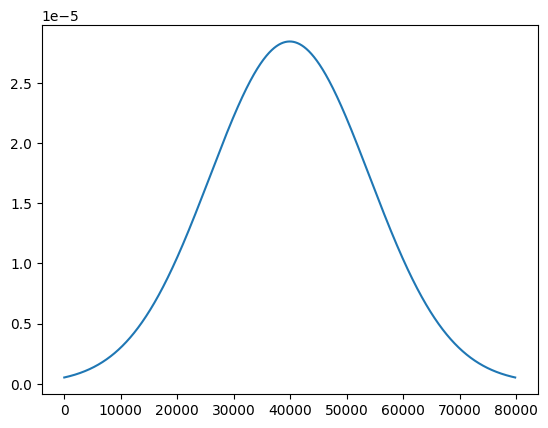

In [14]:
window_size = len(losses) // 20
window_xs = np.linspace(-2, 2, window_size)
window_form = jnp.exp(-window_xs**2)
window = window_form / sum(window_form)

plt.plot(range(window_size), window)

In [15]:
losses_jax = jnp.array(losses)

In [16]:
jnp.save('geometry_ybias_adaptive_2', losses_jax)

In [17]:
losses_ = jnp.ones(shape=(losses_jax.shape[0]+2*window_size))
a = window_size
b = a + losses_jax.shape[0]
losses_ = losses_.at[a:b].set(losses_jax)
losses_ = losses_.at[:a].set(losses_jax[:a][::-1])
losses_ = losses_.at[b:].set(losses_jax[-a:][::-1])
running_avg = jnp.convolve(losses_, window, mode='same')[a:b]

In [ ]:
plt.figure(dpi=300)
# plt.plot(jnp.arange(0, len(losses)), losses, ',', label="Raw data")
# plt.plot(jnp.arange(0, len(losses)), running_avg, label="Running AVG", c='k')
plt.hist2d(jnp.arange(0, len(losses)), losses_jax, bins=(
    jnp.arange(0, len(losses), 25_000),
    jnp.logspace(-6, 1, 128)
), cmap='viridis')
plt.xlim(0, len(losses))
# plt.ylim(ymin = running_avg.min())
# plt.legend()
plt.yscale( "log" )
plt.title("Mean-square error loss vs training batch")
plt.xlabel("Batch number (higher = more training)")
plt.ylabel("Loss (lower = higher accuracy)")
plt.show()

In [6]:
# Generate data
batch_size = 1_000_000
p = .03
nu = 1
error_prob = [
    1 / (2 * (nu + 1)) * p,
    nu / (nu + 1) * p,
    1 / (2 * (nu + 1)) * p,
]
error_weights = jnp.log(jnp.array(error_prob)) / jnp.log(max(error_prob))
# error_prob = [.01, .01, .01]
subkey, key = jax.random.split(key)
syndromes, logicals = gen_data(error_prob, info, ndq, batch_size=batch_size, key=subkey)

# Run the neural network and round it's prediction to the nearest integer
NN_probs = jax.nn.sigmoid(NN_batch(syndromes, error_weights, params))
NN_logicals = jnp.where(NN_probs>0.5, 1, 0)

ValueError: vmap in_axes must be an int, None, or a tuple of entries corresponding to the positional arguments passed to the function, but got len(in_axes)=2, len(args)=3

In [42]:
# Evaluate the MWPM decoder on the same dataset
MWPM = Matching(jnp.append(info['Sx'], info['Sz'], axis=1))
decoding = MWPM.decode_batch(syndromes)
recovery = jnp.where(decoding[:,:ndq]==1, jnp.where(decoding[:,ndq:]==1, 2, 1), jnp.where(decoding[:,ndq:]==1, 3, 0))
MWPM_logicals = jax_get_syndromes_batch(info['Lx'], info['Ly'], info['Lz'], recovery)

In [43]:
NN_errors = (logicals+NN_logicals)%2
NN_rates = [
    jnp.equal(NN_errors, jnp.array([1,0])).all(axis=1).sum() / batch_size,
    jnp.equal(NN_errors, jnp.array([1,1])).all(axis=1).sum() / batch_size,
    jnp.equal(NN_errors, jnp.array([0,1])).all(axis=1).sum() / batch_size,
]

MWPM_errors = (logicals+MWPM_logicals)%2
MWPM_rates = [
    jnp.equal(MWPM_errors, jnp.array([1,0])).all(axis=1).sum() / batch_size,
    jnp.equal(MWPM_errors, jnp.array([1,1])).all(axis=1).sum() / batch_size,
    jnp.equal(MWPM_errors, jnp.array([0,1])).all(axis=1).sum() / batch_size,
]

In [44]:
print("\t\t\tPauli-X\tPauli-Y\tPauli-Z")
print(f"Physical error rates:\t\t{error_prob[0]:7.2E}\t{error_prob[1]:7.2E}\t{error_prob[2]:7.2E}")
print(f"NN prediction error rates:\t{NN_rates[0]:7.2E}\t{NN_rates[1]:7.2E}\t{NN_rates[2]:7.2E}")
print(f"MWPM decoding error rates:\t{MWPM_rates[0]:7.2E}\t{MWPM_rates[1]:7.2E}\t{MWPM_rates[2]:7.2E}")

			Pauli-X	Pauli-Y	Pauli-Z
Physical error rates:		7.50E-03	1.50E-02	7.50E-03
NN prediction error rates:	2.41E-03	1.03E-04	2.03E-03
MWPM decoding error rates:	2.77E-03	9.20E-05	2.72E-03


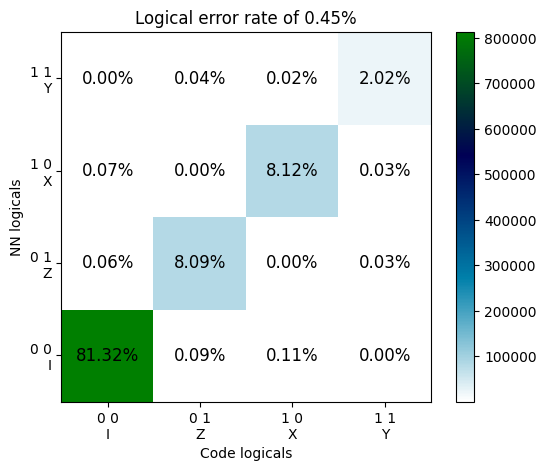

In [45]:
# Calculate the 2d histogram that correlates the actual logicals with the NN prediction
i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * NN_logicals[:, 0] + NN_logicals[:, 1]
hist2d = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plt.figure()
img = plt.imshow(hist2d, origin='lower', cmap='ocean_r')
plt.colorbar(img)
plt.xticks(range(4), labels)
plt.yticks(range(4), labels)
plt.xlabel('Code logicals')
plt.ylabel('NN logicals')
for syndromes, row in enumerate(jnp.array(hist2d).T):
    for y, count in enumerate(row):
        plt.text(syndromes, y, f'{count/hist2d.sum():.2%}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
plt.title(f'Logical error rate of {1 - hist2d.diagonal().sum() / hist2d.sum():.2%}')
plt.show()

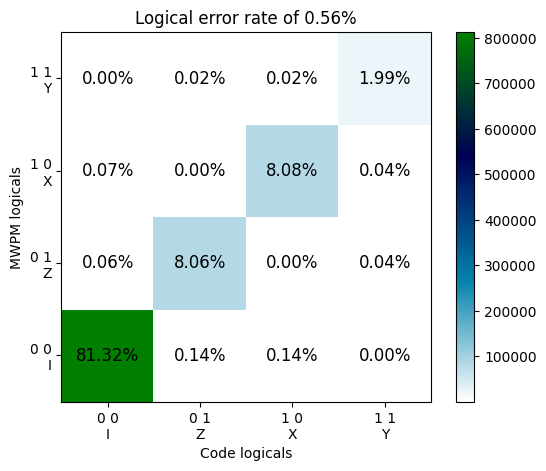

In [46]:
# Calculate the 2d histogram that correlates the actual logicals with the NN prediction
i = 2 * logicals[:, 0] + logicals[:, 1]
j = 2 * MWPM_logicals[:, 0] + MWPM_logicals[:, 1]
hist2d = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plt.figure()
img = plt.imshow(hist2d, origin='lower', cmap='ocean_r')
plt.colorbar(img)
plt.xticks(range(4), labels)
plt.yticks(range(4), labels)
plt.xlabel('Code logicals')
plt.ylabel('MWPM logicals')
for syndromes, row in enumerate(jnp.array(hist2d).T):
    for y, count in enumerate(row):
        plt.text(syndromes, y, f'{count/hist2d.sum():.2%}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
plt.title(f'Logical error rate of {1 - hist2d.diagonal().sum() / hist2d.sum():.2%}')
plt.show()

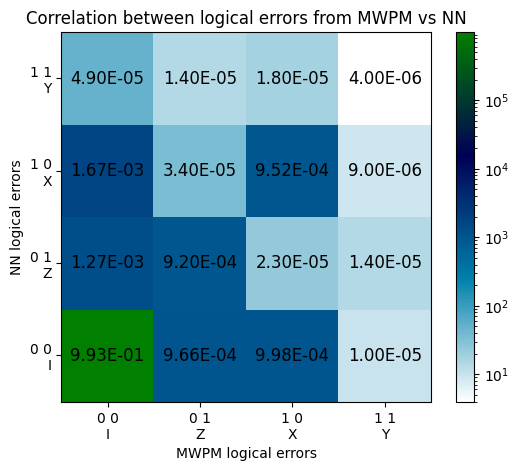

In [40]:
from matplotlib.colors import LogNorm

# Calculate the 2d histogram that correlates the actual logicals with the NN prediction
i = 2 * MWPM_errors[:, 0] + MWPM_errors[:, 1]
j = 2 * NN_errors[:, 0] + NN_errors[:, 1]
hist2d = jnp.zeros((4, 4), dtype=int).at[j, i].add(1)

labels = ['0 0\nI', '0 1\nZ', '1 0\nX', '1 1\nY']

plt.figure()
img = plt.imshow(hist2d, origin='lower', cmap='ocean_r', norm=LogNorm())
plt.colorbar(img)
plt.xticks(range(4), labels)
plt.yticks(range(4), labels)
plt.xlabel('MWPM logical errors')
plt.ylabel('NN logical errors')
for syndromes, row in enumerate(jnp.array(hist2d).T):
    for y, count in enumerate(row):
        plt.text(syndromes, y, f'{count/hist2d.sum():7.2E}', ha='center', va='center', rotation=0, rotation_mode='anchor', fontsize=12)
plt.title(f'Correlation between logical errors from MWPM vs NN')
plt.show()